# This notebook is meant to draw all the plots regarding ddPCM paper

___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# A function that reads .fmm and .dense output files
def read_output_file(fname):
    # Init output dict
    result = {}
    # Read entire file in a single shot
    with open(fname, "r") as fd:
        lines = fd.readlines()
    # Number of atoms
    natoms = int(lines[18].split()[0])
    result["natoms"] = natoms
    #print(natoms)
    # Find start of output
    iline = 0
    while(lines[iline] != "=====OUTPUT=====\n"):
        #print(iline, lines[iline])
        iline += 1
    # Read time of mkrhs
    iline += 2
    result["mkrhs time"] = float(lines[iline].split()[2])
    # Cycle through iterations of the ddPCM system
    iline += 1
    while(lines[iline][:5] != "ddpcm"):
        #print(iline, lines[iline])
        iline += 1
    result["ddpcm step time"] = float(lines[iline].split()[3])
    iline += 1
    result["ddpcm step niter"] = int(lines[iline].split()[3])
    # Cycle through iterations of the ddCOSMO system
    iline += 1
    while(lines[iline][:7] != "ddcosmo"):
        #print(iline, lines[iline])
        iline += 1
    result["ddcosmo step time"] = float(lines[iline].split()[3])
    iline += 1
    result["ddcosmo step niter"] = int(lines[iline].split()[3])
    # Cycle through iterations of the adjoint ddCOSMO system
    iline += 1
    while(lines[iline][:7] != "adjoint"):
        #print(iline, lines[iline])
        iline += 1
    result["adjoint ddcosmo step time"] = float(lines[iline].split()[4])
    iline += 1
    result["adjoint ddcosmo step niter"] = int(lines[iline].split()[4])
    # Cycle through iterations of the adjoint ddPCM system
    iline += 1
    while(lines[iline][:7] != "adjoint"):
        #print(iline, lines[iline])
        iline += 1
    result["adjoint ddpcm step time"] = float(lines[iline].split()[4])
    iline += 1
    result["adjoint ddpcm step niter"] = int(lines[iline].split()[4])
    # Total ddPCM time
    iline += 1
    result["ddpcm time"] = float(lines[iline].split()[2])
    iline += 1
    result["ddpcm esolv"] = float(lines[iline].split()[2])
    # Forces
    iline += 2
    forces = np.zeros((natoms, 3))
    for i in range(natoms):
        forces[i] = list(map(float, lines[iline].split()[1:]))
        iline += 1
    result["ddpcm forces"] = forces
    return result

___

## 1. Comparison of a dense ddPCM solver against FMM ddPCM solver
 
- Maximal degree of modeling spherical harmonics:
    - lmax=6,8,10,12
- Maximal degree of the FMM spherical harmonics:
    - pm=pl=pmax=40 
- Number of Lebedev grid points:
    - ngrid=590

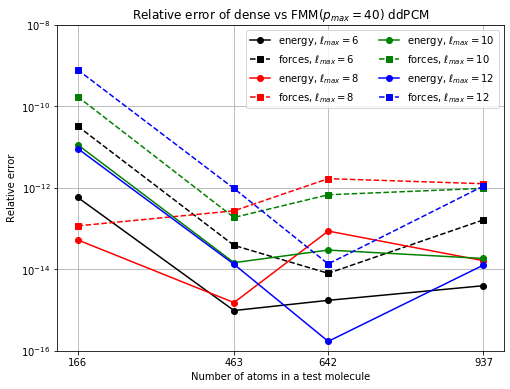

In [12]:
# Plot dense vs fmm results for lmax=6, 8, 10 and 12
lmaxs = [6, 8, 10, 12]
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas"]
natoms = [166, 463, 642, 937]
styles = {6: {"color": "black"},
          8: {"color": "red"},
          10: {"color": "green"},
          12: {"color": "blue"}}
# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))
# Add plots to the figure
for lmax in lmaxs:
    rel_err_esolv = []
    rel_err_forces = []
    for mol in molecules:
        fname_fmm = "dense_vs_fmm_sas/{}.{}.fmm".format(mol, lmax)
        #print("Read:", fname_fmm)
        result_fmm = read_output_file(fname_fmm)
        fname_dense = "dense_vs_fmm_sas/{}.{}.dense".format(mol, lmax)
        #print("Read:", fname_dense)
        result_dense = read_output_file(fname_dense)
        rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_dense["ddpcm esolv"]) /
                            result_dense["ddpcm esolv"]))
        rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_dense["ddpcm forces"]) /
                            np.linalg.norm(result_dense["ddpcm forces"]))
    #print(rel_err_esolv)
    #print(rel_err_forces)
    ax.semilogy(natoms, rel_err_esolv, label="energy, $\ell_{{max}}={}$".format(lmax),
                markersize=6, marker="o",
                linestyle="-", **styles[lmax])
    ax.semilogy(natoms, rel_err_forces, label="forces, $\ell_{{max}}={}$".format(lmax),
                markersize=6, marker="s",
                linestyle="dashed", **styles[lmax])
ax.grid()
ax.set_xticks(natoms)
ax.set_ylim([1e-16, 1e-8])
ax.set_title("Relative error of dense vs FMM($p_{{max}}=40$) ddPCM")
ax.set_xlabel("Number of atoms in a test molecule")
ax.set_ylabel("Relative error")
ax.legend(loc="upper right", ncol=2)
plt.savefig("dense_vs_fmm_sas.pdf")
plt.savefig("dense_vs_fmm_sas.pgf")
plt.show()
plt.close()

___

## 2. Comparison of a FMM solver against FMM(pmax=20) ddPCM solver

Different maximal degree of modeling spherical harmonics correspond to different pmax values:
- lmax=6
    - pmax=0, 2, 4, 5, 6, 7, 8, 10, 12, 15
- lmax=8
    - pmax=0, 2, 4, 6, 7, 8, 9, 10, 12, 15
- lmax=10
    - pmax=0, 2, 4, 6, 8, 9, 10, 11, 12, 15
- lmax=12
    - pmax=0, 3, 6, 8, 10, 11, 12, 13, 14, 16

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


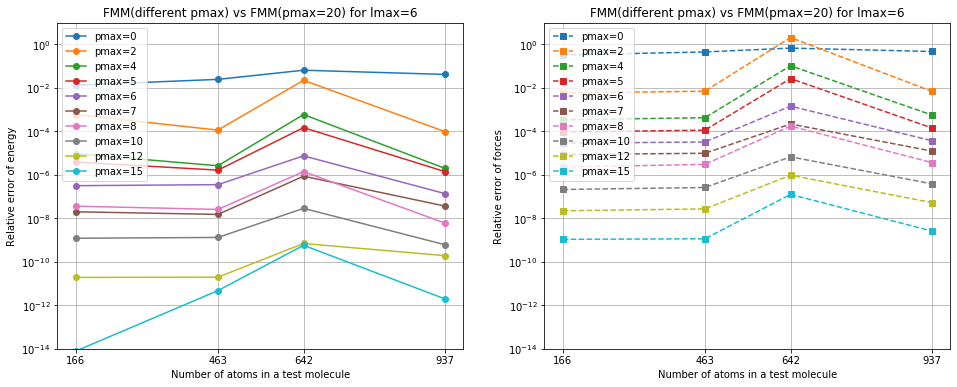

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


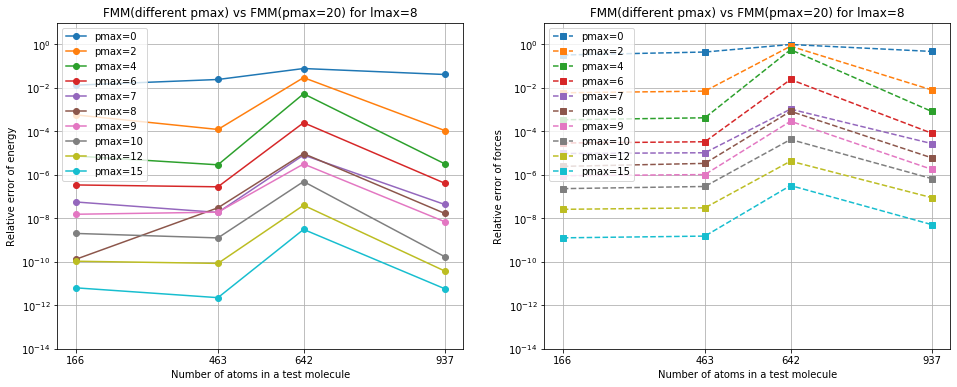

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


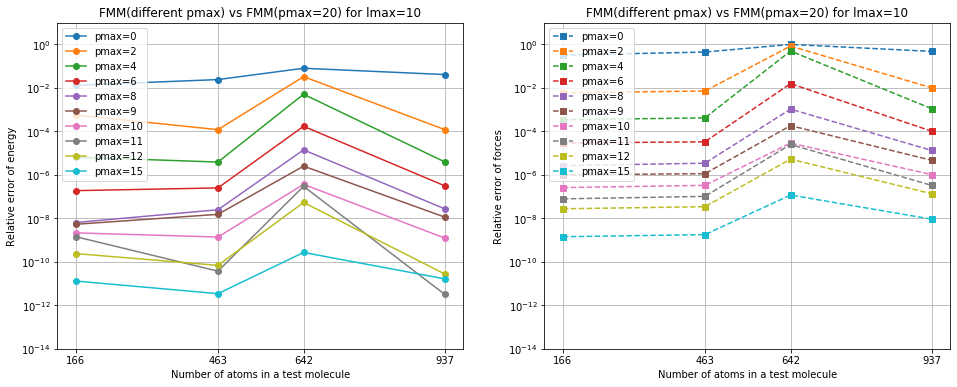

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


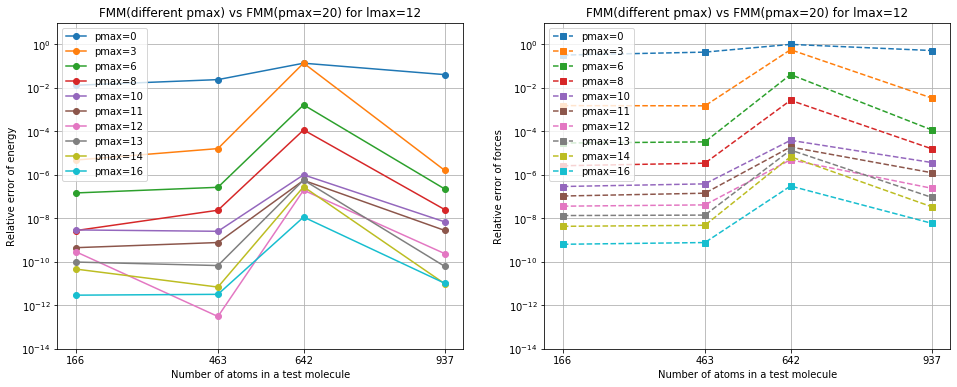

In [5]:
# Plot fmm vs fmm results for lmax=6, 8, 10 and 12 in different plots
lmaxs = [6, 8, 10, 12]
# Possible values of pmax for every lmax
pmaxs = {6: [0, 2, 4, 5, 6, 7, 8, 10, 12, 15],
         8: [0, 2, 4, 6, 7, 8, 9, 10, 12, 15],
         10: [0, 2, 4, 6, 8, 9, 10, 11, 12, 15],
         12: [0, 3, 6, 8, 10, 11, 12, 13, 14, 16]}
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd", "2mlt_monomer", "1ejg", "2mlt"]#, "2qho_a", "2qho_ab", "2qho_abc", "2qho_abcd", "2qho"]
natoms = [166, 463, 642, 937]#, 1922, 3932, 5941, 7887, 8799]
# One plot for each lmax
for lmax in lmaxs:
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    for pmax in pmaxs[lmax]:
        rel_err_esolv = []
        rel_err_forces = []
        for mol in molecules:
            fname_fmm = "fmm_vs_fmm/{}.{}.{}.fmm".format(mol, lmax, pmax)
            #print("Read:", fname_fmm)
            result_fmm = read_output_file(fname_fmm)
            fname_fmm20 = "fmm_vs_fmm/{}.{}.{}.fmm".format(mol, lmax, 20)
            #print("Read:", fname_fmm20)
            result_fmm20 = read_output_file(fname_fmm20)
            rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_fmm20["ddpcm esolv"]) /
                                result_fmm20["ddpcm esolv"]))
            rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_fmm20["ddpcm forces"]) /
                                np.linalg.norm(result_fmm20["ddpcm forces"]))
        #print(rel_err_esolv)
        #print(rel_err_forces)
        axs[0].semilogy(natoms, rel_err_esolv, label="pmax={}".format(pmax), markersize=6, marker="o",
                    linestyle="-")
        axs[1].semilogy(natoms, rel_err_forces, label="pmax={}".format(pmax), markersize=6, marker="s",
                    linestyle="dashed")
    axs[0].grid()
    axs[1].grid()
    axs[0].set_xticks(natoms)
    axs[1].set_xticks(natoms)
    axs[0].set_ylim([1e-14, 1e+1])
    axs[1].set_ylim([1e-14, 1e+1])
    axs[0].set_title("FMM(different pmax) vs FMM(pmax=20) for lmax={}".format(lmax))
    axs[1].set_title("FMM(different pmax) vs FMM(pmax=20) for lmax={}".format(lmax))
    axs[0].set_xlabel("Number of atoms in a test molecule")
    axs[1].set_xlabel("Number of atoms in a test molecule")
    axs[0].set_ylabel("Relative error of energy")
    axs[1].set_ylabel("Relative error of forces")
    axs[0].legend(loc="upper left")
    axs[1].legend(loc="upper left")
    plt.savefig("fmm_vs_fmm_{}.pdf".format(lmax))
    plt.savefig("fmm_vs_fmm_{}.eps".format(lmax))
    plt.show()
    plt.close()

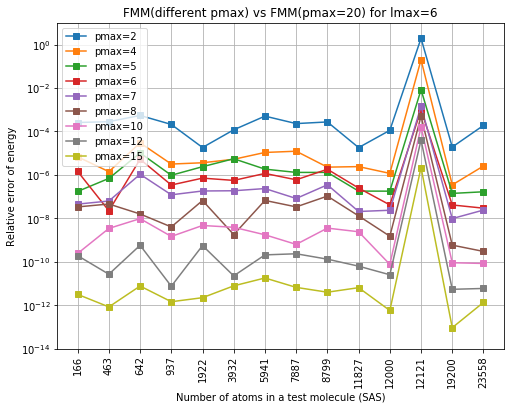

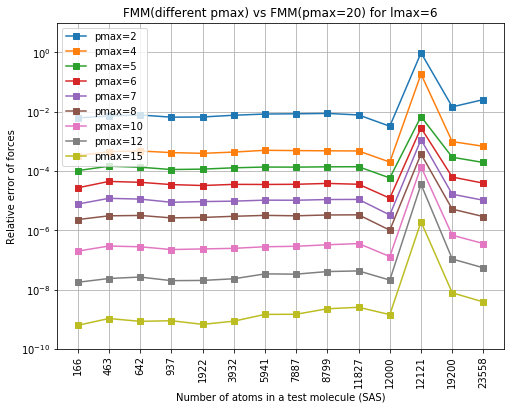

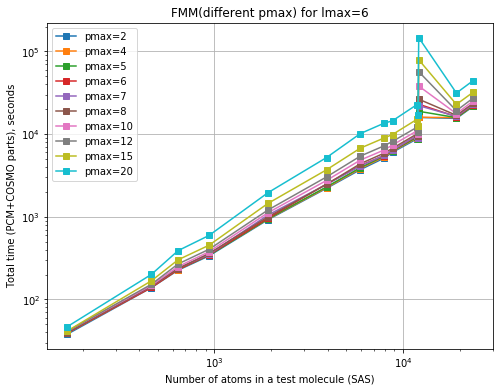

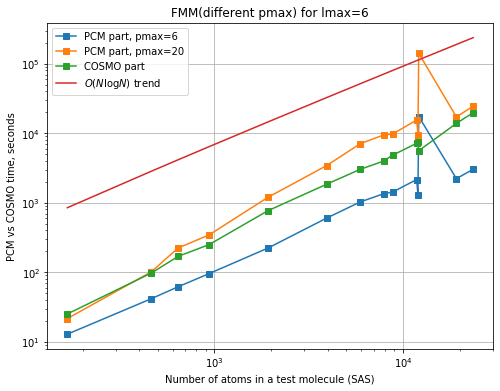

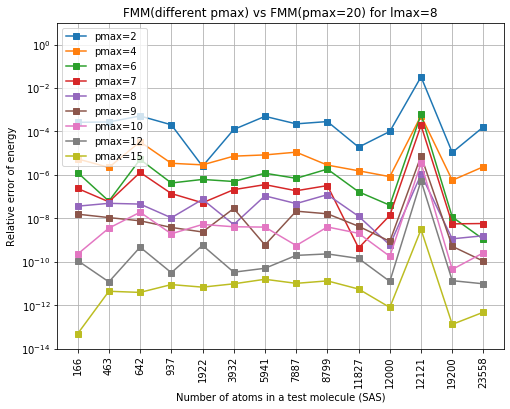

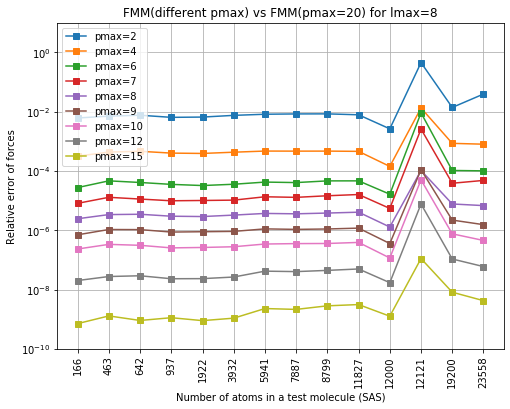

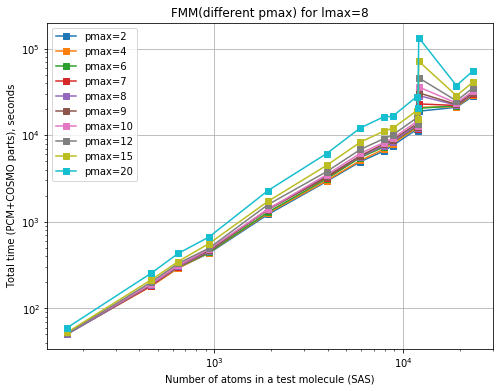

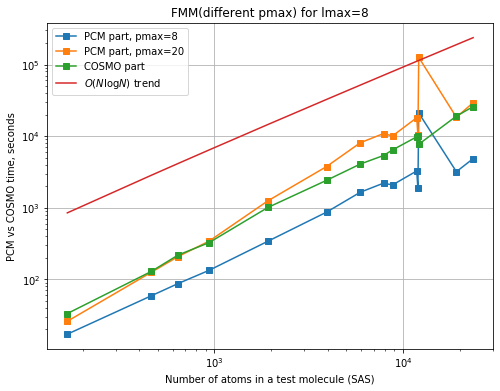

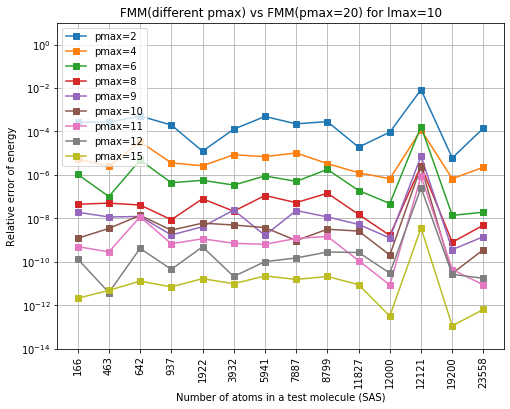

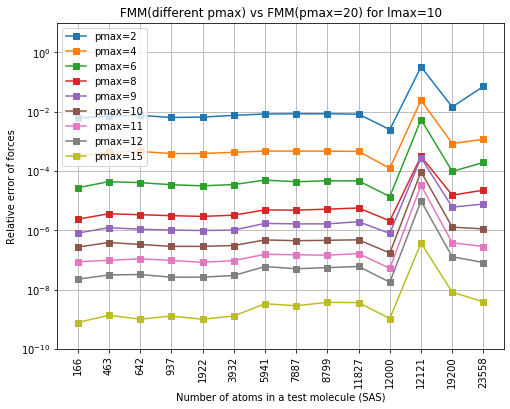

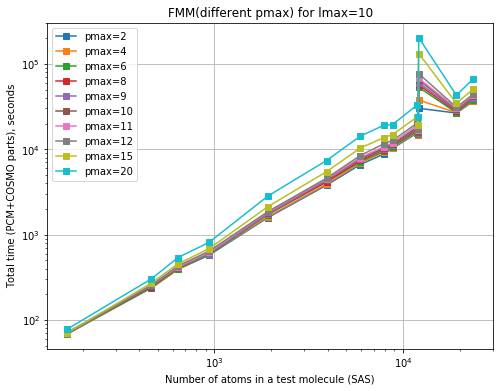

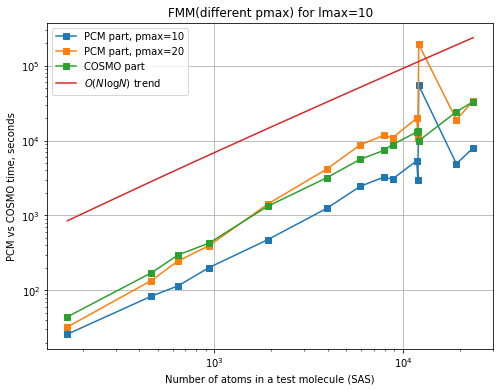

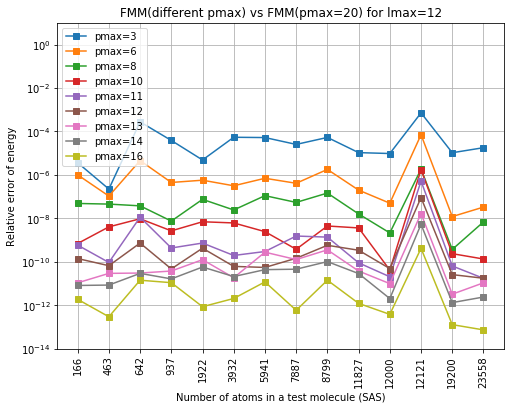

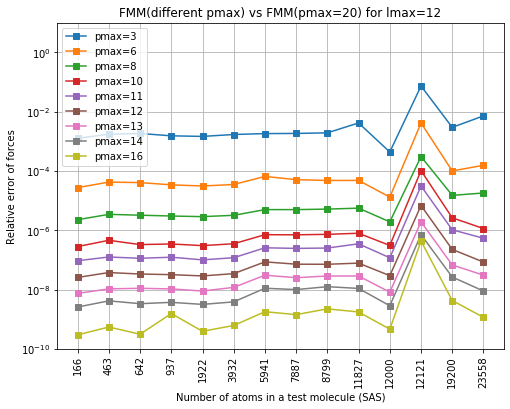

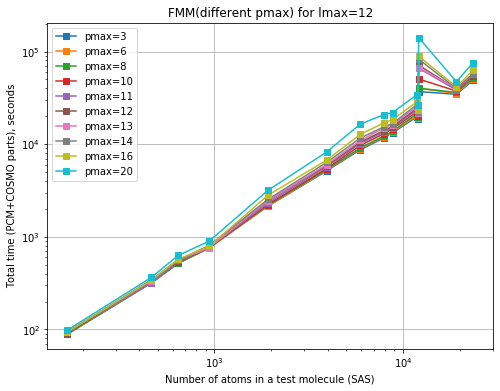

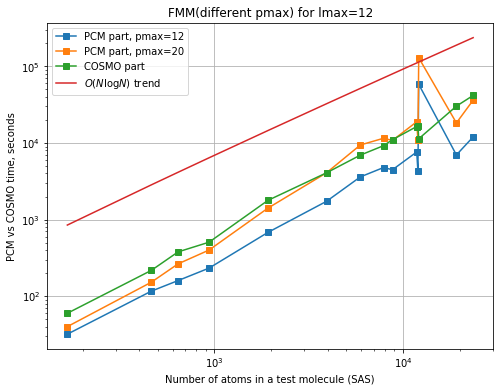

In [118]:
# SAS
# Plot fmm vs fmm results for lmax=6, 8, 10 and 12 in different plots
lmaxs = [6, 8, 10, 12]
# Possible values of pmax for every lmax
pmaxs = {6: [2, 4, 5, 6, 7, 8, 10, 12, 15],
         8: [2, 4, 6, 7, 8, 9, 10, 12, 15],
         10: [2, 4, 6, 8, 9, 10, 11, 12, 15],
         12: [3, 6, 8, 10, 11, 12, 13, 14, 16]}
# Values of pmax to show in scaling
pmaxs_scale1 = {6: [2, 4, 5, 6, 7, 8, 10, 12, 15],
         8: [2, 4, 6, 7, 8, 9, 10, 12, 15],
         10: [2, 4, 6, 8, 9, 10, 11, 12, 15],
         12: [3, 6, 8, 10, 11, 12, 13, 14, 16]}
pmaxs_scale2 = {6: [6],
         8: [8],
         10: [10],
         12: [12]}
# List output molecules in a proper order (increasing number of atoms)
#molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
#             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas"]
#natoms = [166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799]
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterhuge_sas", "photo_sas",
             "waterglobe_sas", "dhfr_sas"]
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 12000, 12121,
          19200, 23558])
xticks = range(len(natoms))
# One plot for each lmax
for lmax in lmaxs:
    # Read data for pmax=20
    result_fmm20 = {}
    for mol in molecules:
        fname_fmm20 = "fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, 20)
        result_fmm20[mol] = read_output_file(fname_fmm20)
    # Create figure
    fig_esolv, ax_esolv = plt.subplots(figsize=(8,6))
    ax_esolv.grid()
    ax_esolv.set_xticks(xticks)
    ax_esolv.set_xticklabels(natoms, rotation="vertical")
    ax_esolv.set_xlabel("Number of atoms in a test molecule (SAS)")
    ax_esolv.set_ylim([1e-14, 1e+1])
    ax_esolv.set_title("FMM(different pmax) vs FMM(pmax=20) for lmax={}".format(lmax))
    ax_esolv.set_ylabel("Relative error of energy")
    fig_force, ax_force = plt.subplots(figsize=(8,6))
    ax_force.grid()
    ax_force.set_xticks(xticks)
    ax_force.set_xticklabels(natoms, rotation="vertical")
    ax_force.set_xlabel("Number of atoms in a test molecule (SAS)")
    ax_force.set_ylim([1e-10, 1e+1])
    ax_force.set_title("FMM(different pmax) vs FMM(pmax=20) for lmax={}".format(lmax))
    ax_force.set_ylabel("Relative error of forces")
    fig_time, ax_time = plt.subplots(figsize=(8,6))
    ax_time.grid()
    ax_time.set_xticks(xticks)
    ax_time.set_xticklabels([])
    ax_time.set_xlabel("Number of atoms in a test molecule (SAS)")
    ax_time.set_title("FMM(different pmax) for lmax={}".format(lmax))
    ax_time.set_ylabel("Total time (PCM+COSMO parts), seconds")
    fig_time2, ax_time2 = plt.subplots(figsize=(8,6))
    ax_time2.grid()
    ax_time2.set_xticks(xticks)
    ax_time2.set_xticklabels([])
    ax_time2.set_xlabel("Number of atoms in a test molecule (SAS)")
    ax_time2.set_title("FMM(different pmax) for lmax={}".format(lmax))
    ax_time2.set_ylabel("PCM vs COSMO time, seconds")
    # Draw plots on error of energy and forces
    for pmax in pmaxs[lmax]:
        rel_err_esolv = []
        rel_err_forces = []
        total_time = []
        pcm_time = []
        cosmo_time = []
        for mol in molecules:
            # Read file with a given pmax
            fname_fmm = "fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
            result_fmm = read_output_file(fname_fmm)
            # Generate data to plot
            rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_fmm20[mol]["ddpcm esolv"]) /
                                result_fmm20[mol]["ddpcm esolv"]))
            rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_fmm20[mol]["ddpcm forces"]) /
                                np.linalg.norm(result_fmm20[mol]["ddpcm forces"]))
            total_time.append(result_fmm["ddpcm time"])
            cosmo_time.append(result_fmm["ddcosmo step time"] + result_fmm["adjoint ddcosmo step time"])
            pcm_time.append(total_time[-1] - cosmo_time[-1])
        ax_esolv.semilogy(xticks, rel_err_esolv, label="pmax={}".format(pmax), markersize=6, marker="s")
        ax_force.semilogy(xticks, rel_err_forces, label="pmax={}".format(pmax), markersize=6, marker="s")
        if pmax in pmaxs_scale1[lmax]:
            ax_time.plot(natoms, total_time, label="pmax={}".format(pmax), markersize=6, marker="s")
        if pmax in pmaxs_scale2[lmax]:
            ax_time2.loglog(natoms, pcm_time, label="PCM part, pmax={}".format(pmax), markersize=6, marker="s")
    # Add pmax=20 plot
    total_time20 = []
    pcm_time20 = []
    cosmo_time20 = []
    for mol in molecules:
        total_time20.append(result_fmm20[mol]["ddpcm time"])
        cosmo_time20.append(result_fmm20[mol]["ddcosmo step time"]
                          + result_fmm20[mol]["adjoint ddcosmo step time"])
        pcm_time20.append(total_time20[-1] - cosmo_time20[-1])
    total_time20 = np.array(total_time20)
    pcm_time20 = np.array(pcm_time20)
    cosmo_time20 = np.array(cosmo_time20)
    ax_time.loglog(natoms, total_time20, label="pmax={}".format(20), markersize=6, marker="s")
    ax_time2.loglog(natoms, pcm_time20, label="PCM part, pmax={}".format(20), markersize=6, marker="s")
    # Add cosmo time to a plot with pcm timing
    ax_time2.loglog(natoms, cosmo_time, label="COSMO part", markersize=6, marker="s")
    # Add a trend line
    ax_time2.loglog(natoms, natoms*np.log(natoms), label="$O(N \\log N)$ trend")
    # Add legend
    ax_esolv.legend(loc="upper left")
    ax_force.legend(loc="upper left")
    ax_time.legend(loc="upper left")
    ax_time2.legend(loc="upper left")
    fig_esolv.savefig("fmm_vs_fmm_sas_esolv_{}.pdf".format(lmax))
    fig_force.savefig("fmm_vs_fmm_sas_force_{}.pdf".format(lmax))
    fig_time.savefig("fmm_vs_fmm_sas_time_{}.pdf".format(lmax))
    fig_time2.savefig("fmm_vs_fmm_sas_time2_{}.pdf".format(lmax))
    plt.show()
    plt.close()

___

## 3. Comparison of pmax=12 vs pmax=20 for different lmax

Comparison for lmax=6,8,10 and 12

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


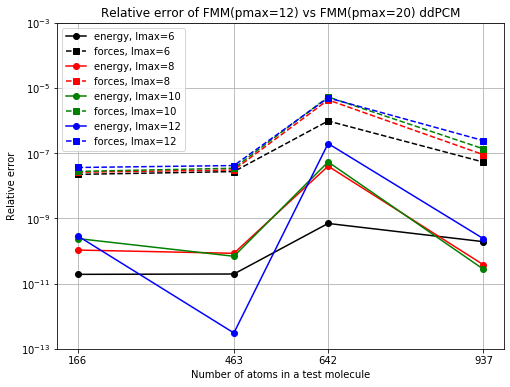

In [13]:
# Plot fmm vs fmm results for pmax=12 vs pmax=20 and lmax=6, 8, 10 and 12 in a single plot
pmax = 12
lmaxs = [6, 8, 10, 12]
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd", "2mlt_monomer", "1ejg", "2mlt"]#, "2qho_a", "2qho_ab", "2qho_abc", "2qho_abcd", "2qho"]
natoms = [166, 463, 642, 937]#, 1922, 3932, 5941, 7887, 8799]
# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))
# Add plots to the figure
for lmax in lmaxs:
    rel_err_esolv = []
    rel_err_forces = []
    for mol in molecules:
        fname_fmm = "fmm_vs_fmm/{}.{}.{}.fmm".format(mol, lmax, pmax)
        #print("Read:", fname_fmm)
        result_fmm = read_output_file(fname_fmm)
        fname_dense = "fmm_vs_fmm/{}.{}.{}.fmm".format(mol, lmax, 20)
        #print("Read:", fname_dense)
        result_dense = read_output_file(fname_dense)
        rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_dense["ddpcm esolv"]) /
                            result_dense["ddpcm esolv"]))
        rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_dense["ddpcm forces"]) /
                            np.linalg.norm(result_dense["ddpcm forces"]))
    #print(rel_err_esolv)
    #print(rel_err_forces)
    ax.semilogy(natoms, rel_err_esolv, label="energy, lmax={}".format(lmax), markersize=6, marker="o",
                linestyle="-", **styles[lmax])
    ax.semilogy(natoms, rel_err_forces, label="forces, lmax={}".format(lmax), markersize=6, marker="s",
                linestyle="dashed", **styles[lmax])
ax.grid()
ax.set_xticks(natoms)
ax.set_ylim([1e-13, 1e-3])
ax.set_title("Relative error of FMM(pmax=12) vs FMM(pmax=20) ddPCM")
ax.set_xlabel("Number of atoms in a test molecule")
ax.set_ylabel("Relative error")
ax.legend(loc="upper left")
plt.savefig("fmm_vs_fmm_pmax.pdf".format(lmax))
plt.savefig("fmm_vs_fmm_pmax.eps".format(lmax))
plt.show()
plt.close()